# Intro to JAX

Author: Adrian Price-Whelan (CCA, 2025)

[Live notebook on Colab](https://colab.research.google.com/github/JAXtronomy/tutorials/blob/main/tutorials/Intro-to-JAX.ipynb)

[Here is the slide deck](../../_static/Intro-to-JAX-for-astronomers.pdf)

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

%xmode minimal

Exception reporting mode: Minimal


## JIT Compilation

Just-in-Time (JIT) compilation enables getting low-level language performance from Python code, on the fly. This can dramatically speed up some numerical computations, especially where loops are required or where the code is not easily vectorized. 

### Example: Computing the gravitational potential of a set of particles

In [2]:
def func(x, a):
    return jnp.log(jnp.sum(x**2, axis=1) + a**2)

In [3]:
x = np.random.normal(size=(1_000_000, 3))

In [4]:
# without JIT:
%timeit func(x, 1.0).block_until_ready()

1.69 ms ± 31.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [5]:
func_jit = jax.jit(func)

# this first call compiles the function
func_jit(x, 1.0).block_until_ready()

# with JIT:
%timeit func_jit(x, 1.0).block_until_ready()

648 μs ± 11.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


This example is a little contrived since the non-JITted version is already vectorized, but it serves to illustrate the JIT compilation process. JIT is most useful when you need to run a function call many times either in a loop or some other iterative process. For example, optimization, MCMC sampling, orbit integration, etc.

BTW: Other packages like Numba and PyTorch also have JIT compilation, but JAX's JIT pairs with XLA to produce highly optimized and hardware-specific machine code.

A brief aside about `.block_until_ready()`: JAX uses lazy evaluation, so it doesn't actually run the code until you need the values. This is great for performance, because JAX will build up a graph of function calls, compile it and send it to XLA for further optimization. But it can be confusing when debugging -- if you don't do this, it can seem like your code is running absurdly fast. `.block_until_ready()` forces JAX to run the code and wait for it to finish before continuing. Compare these:

---

## Vectorization with `vmap`

If your function can be expressed using standard `numpy` operations, writing JAX code with `jax.numpy` to accept arrays as inputs will automatically vectorize the function. However, we often write functions that are not easily vectorized - for example, functions that contain conditional statements or loops. In these cases, `jax.vmap` provides an efficient way to apply a function across batches of inputs, often avoiding explicit (external) loops.

For example, imagine you have a bunch of stellar spectra for a set of stars, and you want to compute the depth of some absorption line that appears at a different location (in pixels) for each star because of doppler shifts. You could write a function that computes the depth of the line for a single spectrum, and then use `jax.vmap` to apply it to all the stars in your dataset. 

### Example: Find the depth of an absorption line in a set of spectra

First we simulate some "spectra":

In [6]:
N = 128  # number of spectra to make

rng = np.random.default_rng(123)
pix = jnp.arange(100)

true_ctr = rng.uniform(40, 60, size=(N,))
true_depth = rng.uniform(0.1, 0.5, size=(N,))


def make_spectrum(pix, ctr, depth, scale):
    return 1 - depth * jnp.exp(-0.5 * (pix - ctr) ** 2 / scale**2)


# we'll use vmap to simulate the spectra too ^_^
spectra = jax.vmap(
    make_spectrum,
    in_axes=(None, 0, 0, None),
    out_axes=0,
)(pix, true_ctr, true_depth, 10.0).block_until_ready()

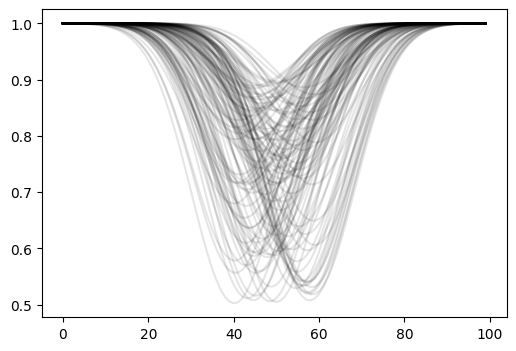

In [7]:
plt.figure(figsize=(6, 4))
_ = plt.plot(spectra.T, "-", alpha=0.1, color="k")

Now we have a set of spectra, and we want to find the depth of the absorption line near pixel ~50. We can write a function that computes the depth of the line for a single spectrum, and then use `jax.vmap` to apply it to all the spectra in our dataset:

In [8]:
def find_depth(spectrum):
    # find the minimum pixel value:
    min_pix = jnp.argmin(spectrum)

    # locally fit a parabola to the spectrum to find the inter-pixel minimum
    y = jax.lax.dynamic_slice(spectrum, (min_pix - 1,), (3,))
    x = jnp.arange(-1, 2)
    A = jnp.vander(x, 3, increasing=True)  # creates a matrix with columns [1, x, x**2]
    coeffs = jnp.linalg.lstsq(A, y, rcond=None)[0]

    return 1 - coeffs[0]


find_depth_vmap = jax.vmap(find_depth, in_axes=0)

In [9]:
%%time
for spectrum in spectra:
    find_depth(spectrum).block_until_ready()

CPU times: user 1.21 s, sys: 76.4 ms, total: 1.29 s
Wall time: 754 ms


In [10]:
%%time
find_depth_vmap(spectra).block_until_ready()

CPU times: user 408 ms, sys: 17.5 ms, total: 426 ms
Wall time: 235 ms


Array([0.20868772, 0.17204314, 0.30131835, 0.3636775 , 0.19127935,
       0.18731236, 0.48143452, 0.3895293 , 0.11364591, 0.49254614,
       0.10336351, 0.20597422, 0.46638107, 0.13210493, 0.4418218 ,
       0.15774381, 0.17152107, 0.41359842, 0.4581688 , 0.28410614,
       0.11531478, 0.22600758, 0.10611612, 0.23952633, 0.36354548,
       0.2059949 , 0.36048532, 0.4705463 , 0.28625727, 0.18262488,
       0.46881056, 0.47813618, 0.15386075, 0.45961618, 0.21669883,
       0.15112185, 0.14722794, 0.40359288, 0.13537681, 0.40483367,
       0.19566655, 0.26736313, 0.157161  , 0.36090612, 0.28279823,
       0.25744826, 0.42169237, 0.28343332, 0.37661898, 0.41251874,
       0.34560823, 0.48450083, 0.3203445 , 0.18747038, 0.31638324,
       0.19761896, 0.13327146, 0.4023258 , 0.20569241, 0.22540128,
       0.49533677, 0.26018262, 0.2763816 , 0.46809173, 0.41601413,
       0.4433542 , 0.2871275 , 0.1847961 , 0.12625158, 0.13186872,
       0.15473187, 0.20758766, 0.4108888 , 0.19163787, 0.26849

Text(0, 0.5, 'True depth')

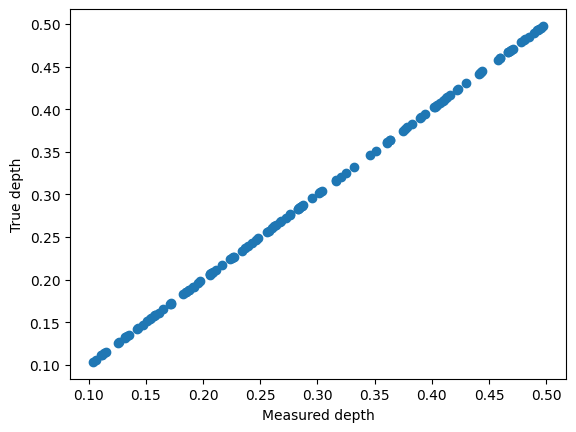

In [11]:
depths = find_depth_vmap(spectra).block_until_ready()
plt.scatter(depths, true_depth)
plt.xlabel("Measured depth")
plt.ylabel("True depth")

---

## Automatic Differentiation

Automatic differentiation (autodiff or autograd) allows you to compute exact gradients of functions. This is generally most useful for simplifying optimization problems (and enabling faster or novel optimization methods).

### Example: Evaluating the gradient of a function

In [12]:
def some_func(x, A, P):
    return A * jnp.cos(2 * jnp.pi * x / P)

In [13]:
some_func_grad = jax.grad(some_func, argnums=0)

xgrid = jnp.linspace(0, 10, 4096)
some_func_grad(xgrid, 1.0, 1.0)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (4096,).

Huh, what happened? Why did this error? `jax.grad` only works on scalar outputs. If we try to pass in an array, the output of `some_func` will be an array. Instead of the above, if we want to compute the gradient for all elements in an array, we can use `jax.vmap` to vectorize the `grad`'ed function:

In [14]:
some_func_grad_vmap = jax.vmap(jax.grad(some_func, argnums=0), in_axes=(0, None, None))

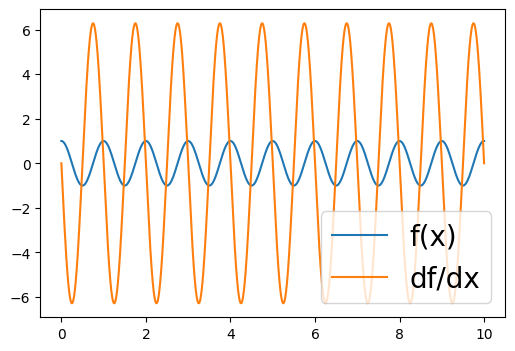

In [15]:
plt.figure(figsize=(6, 4))
plt.plot(xgrid, some_func(xgrid, 1.0, 1.0), "-", label="f(x)")
plt.plot(xgrid, some_func_grad_vmap(xgrid, 1.0, 1.0), "-", label="df/dx")
plt.legend(loc="lower right", fontsize=20)

---

## Pytrees

Pytrees are JAX’s structured data containers. Think of these as dictionaries, where the data may be scalar or array valued and could be arranged hierarchically. JAX functions often take Pytrees as input and output, and they are designed to be compatible with JAX's JIT compilation and autodiff features. Pytrees are one of my favorite features of JAX!

### Example: Computing the gradient of a function with respect to a set of parameters


In [16]:
def model(x, a, b):
    return a * x + b


def objective(params, x, y, y_err):
    model_y = model(x, params["a"], params["b"])
    return jnp.sum((y - model_y) ** 2 / y_err**2)  # chi2

<ErrorbarContainer object of 3 artists>

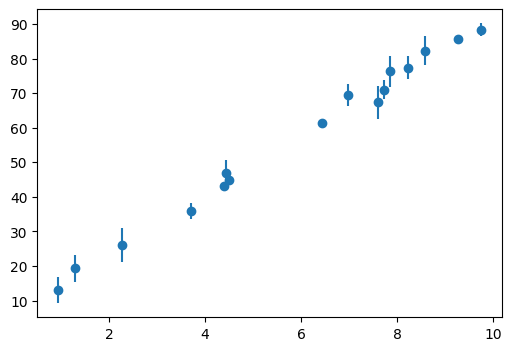

In [17]:
rng = np.random.default_rng(42)
x = rng.uniform(0, 10, size=16)
y = model(x, a=8.67, b=5.309)
y_err = rng.uniform(0.1, 5.0, size=len(x))
y += rng.normal(0, y_err, size=len(x))

plt.figure(figsize=(6, 4))
plt.errorbar(x, y, yerr=y_err, fmt="o", label="data")

In [18]:
objecive_grad = jax.grad(objective, argnums=0)

In [19]:
objecive_grad({"a": 1.0, "b": 1.0}, x, y, y_err)

{'a': Array(-18320.906, dtype=float32, weak_type=True),
 'b': Array(-2312.1978, dtype=float32, weak_type=True)}

### Example: Using `vmap` over a pytree of parameters

You can use `jax.vmap` to efficiently evaluate a function for a batch of pytree keys. Suppose we have arrays of parameter sets and we want to evaluate the function for each set of parameters:

In [20]:
params_arr = {
    "a": jnp.linspace(0, 10, 5),
    "b": jnp.linspace(-5, 5, 5),
}

objective_vmap = jax.vmap(objective, in_axes=({"a": 0, "b": 0}, None, None, None))
chi2_arr = objective_vmap(params_arr, x, y, y_err).block_until_ready()
chi2_arr

Array([110933.7   ,  57136.957 ,  21026.932 ,   2603.595 ,   1866.9546],      dtype=float32)

## Sharp Bits

### Control flow

In general, use `jax.lax.cond` instead of `if` statements, and `jax.lax.scan` instead of `for` loops. This is because JAX uses XLA to compile the code, and XLA needs to know the shape of the data at compile time. 

In [21]:
@jax.jit
def func_if1(x):
    if x > 0:
        return x**3
    else:
        return x**2

In [22]:
func_if1(10.0)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function func_if1 at /var/folders/y0/mjkc7jhs1799z200jjg82lww0000gp/T/ipykernel_35649/1889811532.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [23]:
@jax.jit
def func_if2(x):
    return jax.lax.cond(x > 0, lambda: x**3, lambda: x**2)

In [24]:
func_if2(10.0)

Array(1000., dtype=float32, weak_type=True)

## Teaser: Using physical units in JAX code

`astropy.units` has the `Quantity` object for handling data with associated physical units. However, this is an explicit subclass of `numpy.ndarray`, so JAX does not work natively with Astropy units. Instead, in the meantime, we are building a new package called `unxt` for handling JAX tracers with physical units. This package is still in development, but it is ready for use:

In [26]:
import unxt as u
import quaxed

In [27]:
pos = u.Quantity(jnp.arange(10.0), "kpc")
time = u.Quantity(5.3, "Gyr")

result = pos / time
result.unit

Unit("kpc / Gyr")

In [28]:
def compute_potential(r, GM, a):
    # Gravitational potential for a Hernquist model:
    return -GM / (r + a)

In [29]:
dPhi_dr = quaxed.grad(compute_potential)

In [30]:
r = u.Quantity(1.0, "kpc")
GM = u.Quantity(1.0, "kpc^3 / Gyr^2")
a = u.Quantity(1.0, "kpc")
compute_potential(r, GM, a).block_until_ready()

Quantity(Array(-0.5, dtype=float32, weak_type=True), unit='kpc2 / Gyr2')

In [31]:
dPhi_dr(r, GM, a).block_until_ready()

Quantity(Array(0.25, dtype=float32, weak_type=True), unit='kpc / Gyr2')